# TP Integrador N° 1 
#### Grupo 10

Integrantes:
- Rodrigo Gramajo
- Facundo Peloso
- Roberto Biancardi

Introducción

La inmobiliaria Properatti desea implementar un ***tasador automático*** para sus operaciones.

Nuestro objetivo final es desarrollar un modelo de regresión lineal que permita *predecir el* ***precio por metro cuadrado*** *de una propiedad.* Para ello, la empresa nos provee un dataset con los datos de sus operaciones en el primer semestre del 2017.

El alcance de este primer trabajo práctico es de leer, analizar y procesar dichos datos para desarrollar un modelo predictivo en próximos trabajos.



### Lectura de Datos ###


Importamos las librerías que nos permitiran manejar y visualizar los datos

In [1]:
#Importacion de librerias/módulos
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import collections
import descartes
import geopandas as gpd
from shapely.geometry import Point, polygon
import shapely.wkt

Leemos el archivo .csv que contiene al dataset y  hacemos una primera visualización.

NOTA: El archivo .csv esta ubicado en el mismo directorio que la notebook Main para evitar conflictos de distintas rutas locales.

In [2]:
#Establezco la dirección del archivo
file_location='properatti.csv'

#Leo el data set usando la librería pandas
# y se almacena en el objeto Dataframe llamado datos_crudos  
datos_crudos=pd.read_csv(file_location)

#Visualizo las primeras filas
display(datos_crudos.head(3))

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,...,40.0,1127.272727,1550.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...
2,2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,...,55.0,1309.090909,1309.090909,NaN,NaN,NaN,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...


### Dimensiones del Dataset ###
Visualizamos la dimensión del dataset en filas *(Registros)* y columnas *(Campos)*:

In [3]:
#Imprimimos en pantalla la cantidad de filas y columnas
print('Tamaño del dataset')
print('Filas:',datos_crudos.shape[0])
print('Columnas:',datos_crudos.shape[1])

Tamaño del dataset
Filas: 121220
Columnas: 26


Hay mas 120 mil registro por lo que es de tamaño chico/mediano.

Cuenta con 26 campos para describir cada operacion inmobiliaria.

### Analisis de los Campos ###

Listamos todos los campos del dataset y el tipo de dato que almacenan para entender que información nos brindan

In [4]:
#Instanciamos un Serie vacía
nombre_tipo_columnas=pd.Series()
#Utilizamos las columnas de nuestro dataset como índice de la serie vacía
# como valores guardamos el tipo de objeto almacenado en la primera fila de cada columna
for i in datos_crudos.columns : 
     nombre_tipo_columnas[i]=type(datos_crudos.loc[0,i])
nombre_tipo_columnas


C:\Users\fpeloso\AppData\Local\Temp\ipykernel_11008\1820039734.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  nombre_tipo_columnas=pd.Series()


Unnamed: 0                      <class 'numpy.int64'>
operation                               <class 'str'>
property_type                           <class 'str'>
place_name                              <class 'str'>
place_with_parent_names                 <class 'str'>
country_name                            <class 'str'>
state_name                              <class 'str'>
geonames_id                   <class 'numpy.float64'>
lat-lon                                 <class 'str'>
lat                           <class 'numpy.float64'>
lon                           <class 'numpy.float64'>
price                         <class 'numpy.float64'>
currency                                <class 'str'>
price_aprox_local_currency    <class 'numpy.float64'>
price_aprox_usd               <class 'numpy.float64'>
surface_total_in_m2           <class 'numpy.float64'>
surface_covered_in_m2         <class 'numpy.float64'>
price_usd_per_m2              <class 'numpy.float64'>
price_per_m2                

In [5]:
datos_crudos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121220 entries, 0 to 121219
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0                  121220 non-null  int64  
 1   operation                   121220 non-null  object 
 2   property_type               121220 non-null  object 
 3   place_name                  121197 non-null  object 
 4   place_with_parent_names     121220 non-null  object 
 5   country_name                121220 non-null  object 
 6   state_name                  121220 non-null  object 
 7   geonames_id                 102503 non-null  float64
 8   lat-lon                     69670 non-null   object 
 9   lat                         69670 non-null   float64
 10  lon                         69670 non-null   float64
 11  price                       100810 non-null  float64
 12  currency                    100809 non-null  object 
 13  price_aprox_lo

### Listado y breve descripción de cada campo ###

- "Unnamed: 0": Es un campo que hace la función de índice. Cada registro es un valor numérico, entero, único y ordenado desde el 0 hasta el total de filas menos uno.

- "operation": String que define el tipo de operación: venta(sell) o alquiler(rent).

- property_type: String que define el tipo de propiedad (PH, Casa, Departamento)

- place_name: String que define el barrio/ciudad de la propiedad

- place_with_parent_names: String con diferentes datos geograficos separados por un caracter
 (pais, nombre, provincia, ciudad).

- country_name: String que define el país de la propiedad.

- state_name: String que indica la provincia/región de la propiedad.

- geonames_id:

- lat-lon: Latitud y Longitud separados por un caracter.

- lat: Latidud

- lon: Longitud

- price: Precio 

- currency: Moneda 

- price_aprox_local_currency: Precio en moneda local.

- price_aprox_usd: Precio aproximado en dólares

- surface_total_in_m2: Superficie total en metros cuadrados.

- surface_covered_in_m2: Superficie cubierta/bajo techo en metros cuadrados.

- price_usd_per_m2: Precio en dolar del metro cuadrado de la propiedad.

- price_per_m2: Precio en monedad local del metro cuadrado de la propiedad.

- floor: String que indica el piso en el que se encuentra el departamento o cantidad de pisos que tiene una casa.

- rooms: Cantidad de  ambientes que tiene la propiedad.

- expenses: Valor de las expensas.

- properati_url

- description

- title

- image_thumbnail

### Analisis de los campos del Dataset ###


##### Eliminación de campos: ####

Creamos una lista vacía donde iremos añadiendo los campos redundantes/ innecesarios que serán eliminados

In [6]:
#Lista vacía de campos a eliminar:
campos_a_eliminar=[]

**Unnamed 0:** - Esta columna no tiene ninguna utilidad o función ya que volcamos el dataset a un objeto Dataframe que ya cuenta con su propio índice. Por ende se descarta.

In [7]:
#añadimos el campo a la lista eliminar
campos_a_eliminar.append('Unnamed: 0')

**Operation:** - Esta columna debería tener dos tipos de valores posibles (venta y alquiler). Podemos corrobar cuantos operaciones fueron venta y cuantas alquiler:

In [8]:
#Utilizamos el método value_counts para totalizar las operaciones de venta y alquier 
datos_crudos.operation.value_counts()

sell    121220
Name: operation, dtype: int64

Vemos que todas las operaciones realizadas han sido de ventas y ninguna de alquiler. Por lo tanto, esta columna no me aporta información y se descarta.

In [9]:
#añadimos el campo a la lista eliminar
campos_a_eliminar.append('operation')

**country_name** - A priori se debería descartar ya que, por definición, partimos de la base que la inmobiliaria Properatti es una empresa argentina que opera solo en dicho país. No obstante, podemos corroborar si todos los registros del campo country_name coinciden y son efectivamente "Argentina":

In [10]:
#Utilizamos el método value_counts para totalizar los valores distinto que aparecen
#en la columna country_name
datos_crudos.country_name.value_counts()

Argentina    121220
Name: country_name, dtype: int64

Confirmamos que todos los registros tiene el mismo valor por lo que el campo no aporta información y se decarta la columna.

In [11]:
#añadimos el campo a la lista eliminar
campos_a_eliminar.append('country_name')

place_with_parent_names: Es un campo que contiene la misma información que place_name, state_name y country_name separados
por un caracter "|".

A priori, uno podría descartar esta columna y quedarse con las columnas que cuentan con los valores ya separados.

Sin embargo, vemos que place_name tiene registros nulos y place_with_parent_names no:

In [12]:
datos_crudos[['state_name','place_name','place_with_parent_names']].isnull().sum()

state_name                  0
place_name                 23
place_with_parent_names     0
dtype: int64

Por esto decidimos quedarnos con la ccolumna place_with_parent_names que tiene toda la mayor cantidad de información, 
a pesar que luego tendremos que procesarla.

Descartamos los campos state_name y place_name:

In [13]:
#añadimos los campos a la lista eliminar
campos_a_eliminar.extend(('state_name','place_name'))

geonames_id: Corresponde a una base de datos que asigna latitud y longitud a ciudades, provincias y otras
entidades geográficas.

No es útil para imputar las columnas de latitud y longitud ya que si queremos analizar los precios de las propiedades por barrio, esto introduciría un sesgo a los datos y empeoraría el valor predictivo
de nuestro modelo. Por ende se descarta

In [14]:
#añadimos los campos a la lista eliminar
campos_a_eliminar.append('geonames_id')


lat-lon: Tiene los datos de latitud y longitud separados por un caracter "-".
Podríamos descartala y utilizar las columnas lat y lon en su lugar. Pero primero corroboramos la calidad
de las columnas según cantidad de nulos:

In [15]:
#Vemos la cantidad de nulos en las columnas:
datos_crudos[['lat-lon','lat','lon']].isnull().sum()

lat-lon    51550
lat        51550
lon        51550
dtype: int64

Como tienen la misma cantidad de datos, descartamos la columna lat-lon.

In [16]:
#añadimos los campos a la lista eliminar
campos_a_eliminar.append('lat-lon')

Ahora analizamos las columnas correspondientes al precio de las propiedades

Tenemos las columnas price (precio en dólares), currency(moneda en que se cotiza), 
price_aprox_local_currency (precio aproximado en pesos) y price_aprox_usd (precio aproximado en dólares)


Por un lado vemos que monedas se usaron para cotizar:

In [17]:
#Vemos cuantas monedas se utilizaron
datos_crudos.currency.value_counts()

USD    87587
ARS    13219
PEN        2
UYU        1
Name: currency, dtype: int64

La gran mayoria de las cotizaciones fue en dólares. Deberíamos tener una única columna con el precio de las propiedades en dólares.

Ahora vemos si los precios en pesos han usado el mismo tipo de cambio:

In [18]:
#Creamos un df dividiendo el precio aproximado en pesos por el precio aproximado en dólares
valor_de_cambio=datos_crudos.price_aprox_local_currency/datos_crudos.price_aprox_usd

#Vemos cuantas cotizaciones hubo
valor_de_cambio.value_counts()

17.6445    82402
17.6445      714
17.6445      670
17.6445      224
17.6445      224
           ...  
17.6445        1
17.6445        1
17.6445        1
17.6445        1
17.6445        1
Length: 7238, dtype: int64

In [19]:
#Analizamos los tres casos en donde se utilizaron monedas que no son ni pesos ni dólares

#La cotización resulta igual al tipo de cambio peso/dolar. Asumimos que el precio esta en pesos y hubo 
#un error de tipeo

print(datos_crudos.loc[datos_crudos.currency=='PEN'][['price','price_aprox_usd','price_aprox_local_currency','currency']])
print(datos_crudos.loc[50387,'price_aprox_local_currency']/datos_crudos.loc[50387,'price_aprox_usd'])
print(datos_crudos.loc[50388,'price_aprox_local_currency']/datos_crudos.loc[50388,'price_aprox_usd'])

print(datos_crudos.loc[datos_crudos.currency=='UYU'][['price','price_aprox_usd','price_aprox_local_currency','currency']])
print(datos_crudos.loc[107390,'price_aprox_local_currency']/datos_crudos.loc[107390,'price_aprox_usd'])

          price  price_aprox_usd  price_aprox_local_currency currency
50387  380000.0        117139.33                  2066864.90      PEN
50388  950000.0        292848.33                  5167162.35      PEN
17.644499930125942
17.64449997034301
              price  price_aprox_usd  price_aprox_local_currency currency
107390  650000000.0      22980378.29                4.054773e+08      UYU
17.644499999656013


Todas los precios tienen un tipo de cambio de 17,6445. Probablemente, se haya tomado el tipo de cambio
el dia de la fecha en que se exportó el dataset y se aplicó sobre los precios en dólares.

In [20]:
#Vemos la cantidad de nulos en los campos relativos al precio
datos_crudos[['price','price_aprox_local_currency','price_aprox_usd']].isnull().sum()

price                         20410
price_aprox_local_currency    20410
price_aprox_usd               20410
dtype: int64

Nos quedamos con la columna price_aprox_usd.

In [21]:
#añadimos los campos a la lista eliminar
campos_a_eliminar.extend(('price','price_aprox_local_currency','currency'))

In [22]:
campos_a_eliminar

['Unnamed: 0',
 'operation',
 'country_name',
 'state_name',
 'place_name',
 'geonames_id',
 'lat-lon',
 'price',
 'price_aprox_local_currency',
 'currency']

In [23]:
#Damos de baja las columnas 

datos= datos_crudos.drop(campos_a_eliminar, axis=1)

datos.head(3)

,property_type,place_with_parent_names,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,PH,|Argentina|Capital Federal|Mataderos|,-34.661824,-58.508839,62000.0,55.0,40.0,1127.272727,1550.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,apartment,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,-34.903883,-57.964330,150000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...
2,apartment,|Argentina|Capital Federal|Mataderos|,-34.652262,-58.522982,72000.0,55.0,55.0,1309.090909,1309.090909,NaN,NaN,NaN,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...


### Visualizamos la calidad de cada columna según cantidad de valores nulos

In [24]:
#Creamos dos series donde guardamos los porcentajes de valores nulos y no nulos de cada campo
valores_nulos=datos.isnull().sum()/datos.shape[0]

valores_no_nulos=datos.notnull().sum()/datos.shape[0]

#Usando ambas series, instanciamos un dataframe
df_calidad_columnas=pd.DataFrame(dict(valores_no_nulos=valores_no_nulos,valores_nulos=valores_nulos))

df_calidad_columnas

,valores_no_nulos,valores_nulos
property_type,1.000000,0.000000
place_with_parent_names,1.000000,0.000000
lat,0.574740,0.425260
lon,0.574740,0.425260
price_aprox_usd,0.831628,0.168372
surface_total_in_m2,0.675565,0.324435
surface_covered_in_m2,0.835778,0.164222
price_usd_per_m2,0.566053,0.433947
price_per_m2,0.723131,0.276869
floor,0.065163,0.934837


### Utilizamos un gráfico de barras para visualizar la calidad de las columnas

C:\Users\fpeloso\AppData\Local\Temp\ipykernel_11008\1661578272.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ind)
C:\Users\fpeloso\AppData\Local\Temp\ipykernel_11008\1661578272.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ind, rotation = 90, ha="right")


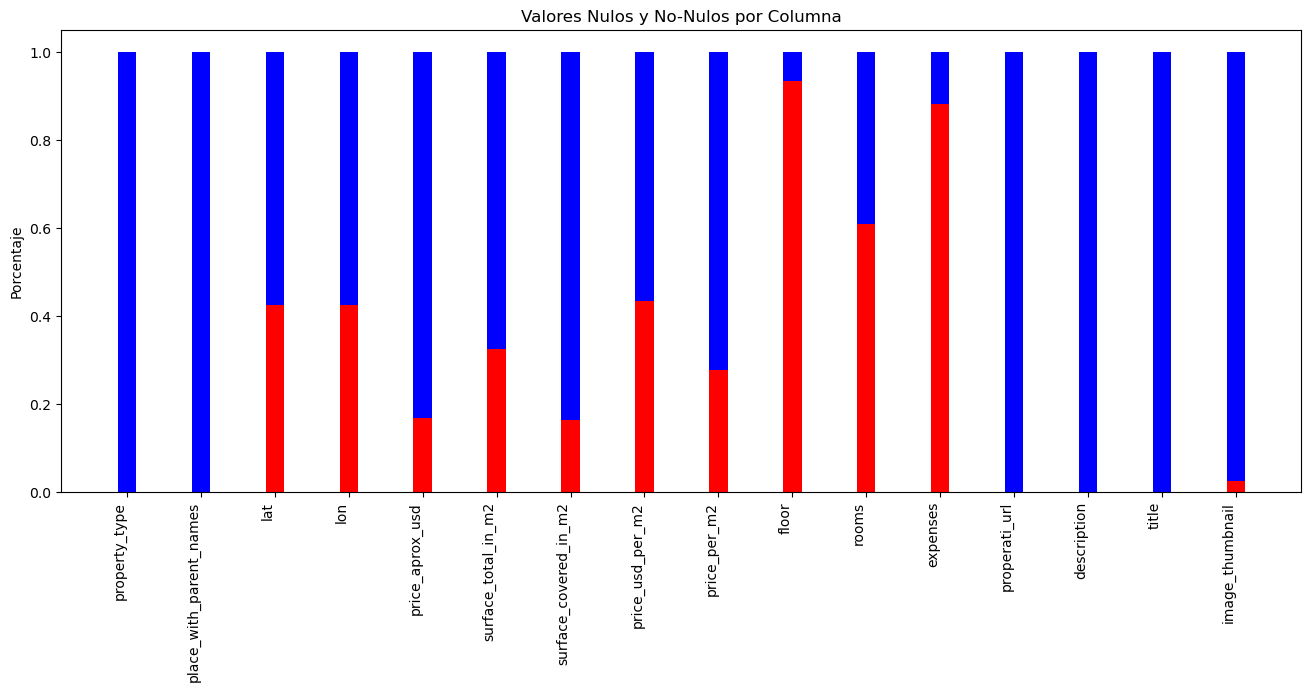

In [25]:
ind=datos.columns
ind_label=np.arange(0,datos.shape[1]-1)

valores_nulos=datos.isnull().sum()/datos.shape[0]

valores_no_nulos=datos.notnull().sum()/datos.shape[0]

width = 0.25

fig = plt.figure(figsize=(16,6)); ax = plt.axes()
#fig2= plt.figure(figsize=(16,6)); ax2 = plt.axes()

ax.bar(ind, valores_nulos, width, color='r') # barra roja. 
ax.bar(ind, valores_no_nulos, width, color='b',bottom=valores_nulos)
#ax2.bar(ind, valores_no_nulos, width, color='b')#, bottom=valores_no_nulos) # barra azul 

ax.set_ylabel('Porcentaje'); ax.set_title('Valores Nulos y No-Nulos por Columna')
#ax.set_xticks(ind); 
ax.set_xticklabels(ind)
ax.tick_params(axis='both', which='minor', labelsize='small')

ax.set_xticklabels(ind, rotation = 90, ha="right")
#ax2.set_xticklabels(ind,labelsize=8)
#ax.legend(labels=['Men', 'Women'])

#plt.gca().invert_xaxis()
plt.show()


In [26]:
#estaria para dropear pric, curency y el precio en moneda local

#usar datos de comentarios para validar, que la información sea consistente 

#validar 

## Procesamiento de columna places para crear nuevas columnas de ubicación geográfica 

In [27]:
#Creo un dataframe nuevo separando los campso de la columna places_with_parents
ubicacion = datos["place_with_parent_names"].str.split('|', expand=True) # Separo en varias columnas
#Visualizamos el dataframe creado:
ubicacion

,0,1,2,3,4,5,6
0,,Argentina,Capital Federal,Mataderos,,None,None
1,,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,,None,None
2,,Argentina,Capital Federal,Mataderos,,None,None
3,,Argentina,Capital Federal,Liniers,,None,None
4,,Argentina,Buenos Aires Costa Atlántica,Mar del Plata,Centro,,None
...,...,...,...,...,...,...,...
121215,,Argentina,Capital Federal,Belgrano,,None,None
121216,,Argentina,Bs.As. G.B.A. Zona Norte,San Isidro,Beccar,,None
121217,,Argentina,Capital Federal,Villa Urquiza,,None,None
121218,,Argentina,Buenos Aires Costa Atlántica,Mar del Plata,Plaza Colón,,None


In [28]:
#Vemos cantidad de valores vacios/nulos en cada columna
for i in range(ubicacion.shape[1]):
    print('Porcentaje vacios en columna', i ,' :' ,ubicacion.iloc[:,i].isna().sum()/ubicacion.shape[0])


Porcentaje vacios en columna 0  : 0.0
Porcentaje vacios en columna 1  : 0.0
Porcentaje vacios en columna 2  : 0.0
Porcentaje vacios en columna 3  : 0.0
Porcentaje vacios en columna 4  : 0.03943243689160204
Porcentaje vacios en columna 5  : 0.6663916845405049
Porcentaje vacios en columna 6  : 0.9954792938459001


Eliminamos la columna 0 por ser un índice redundante, la columna 1 por tener el dato de País que ya decidimos descartar y la columna 6 por su alta tasa de registros vacios.

In [29]:
#Creamos un df con las columnas de interes y el nombre de las columnas
ubicacion_limpia=ubicacion.drop([0,1,6],axis=1,inplace=False)
ubicacion_limpia.columns=['provincia','ciudad','barrio1','barrio2']
ubicacion_limpia

,provincia,ciudad,barrio1,barrio2
0,Capital Federal,Mataderos,,None
1,Bs.As. G.B.A. Zona Sur,La Plata,,None
2,Capital Federal,Mataderos,,None
3,Capital Federal,Liniers,,None
4,Buenos Aires Costa Atlántica,Mar del Plata,Centro,
...,...,...,...,...
121215,Capital Federal,Belgrano,,None
121216,Bs.As. G.B.A. Zona Norte,San Isidro,Beccar,
121217,Capital Federal,Villa Urquiza,,None
121218,Buenos Aires Costa Atlántica,Mar del Plata,Plaza Colón,


In [30]:
#aca pongo capturo los barrios de capital federal que estan en la columna ciudad
#esto se debe a que Capital Federal se guarda en la columna provinci

barrio_limpio=ubicacion_limpia.apply(lambda x: x['ciudad'] if x['provincia'] =='Capital Federal' else x['barrio1'],axis=1)

#precio_m2_imputado=datos.apply(lambda x: x['price']/x['surface_total_in_m2']  if x['price_usd_per_m2'] is np.NAN else x['price_usd_per_m2'], axis=1)
barrio_limpio

0             Mataderos
1                      
2             Mataderos
3               Liniers
4                Centro
              ...      
121215         Belgrano
121216           Beccar
121217    Villa Urquiza
121218      Plaza Colón
121219                 
Length: 121220, dtype: object

In [31]:
ubicacion_limpia['barrio1']=barrio_limpio

In [32]:
ciudad_limpia=ubicacion_limpia.apply(lambda x: x['provincia'] if x['provincia'] =='Capital Federal' else x['ciudad'],axis=1)

In [33]:
ubicacion_limpia['ciudad']=ciudad_limpia

In [34]:
ubicacion_limpia.barrio2.value_counts()

                             39892
Barrio Los Alisos              278
Barrio La Alameda               62
BarrioPortezuelo                54
Barrio Los Lagos                39
Barrio El Golf                  32
Enyoi                           17
Barrio Los Castores             14
QBay Yacht                      13
Barrio Las Glorietas            10
Barrio La Isla                  10
Islas del Canal                  6
Barrio Los Sauces                4
Barrio Barrancas del Lago        4
Barrio Cabos del Lago            3
Barrio Los Tilos                 1
Barrio El Yacht                  1
Name: barrio2, dtype: int64

In [35]:
#Ademas de 40.000 registros vacios, hay mas de 80.000 registros nulos 
ubicacion_limpia.barrio2.isnull().sum()

80780

In [36]:
#Creo una mascara para filtrar los registros vacío y nulos
mascara_barrio2 = ((ubicacion_limpia['barrio2']!='') & (ubicacion_limpia['barrio2'].notnull()))

#Aplicamos el filtro a la columna barrio 2 y vemos cuantos valores quedan
barrio_2_filtrado=ubicacion_limpia['barrio2'].loc[mascara_barrio2]

barrio_2_filtrado.value_counts()

Barrio Los Alisos            278
Barrio La Alameda             62
BarrioPortezuelo              54
Barrio Los Lagos              39
Barrio El Golf                32
Enyoi                         17
Barrio Los Castores           14
QBay Yacht                    13
Barrio La Isla                10
Barrio Las Glorietas          10
Islas del Canal                6
Barrio Los Sauces              4
Barrio Barrancas del Lago      4
Barrio Cabos del Lago          3
Barrio Los Tilos               1
Barrio El Yacht                1
Name: barrio2, dtype: int64

In [37]:
barrio_2_filtrado

17                   Barrio El Golf
33                   Barrio El Golf
278            Barrio Las Glorietas
416                Barrio Los Lagos
446            Barrio Las Glorietas
                    ...            
117011                   QBay Yacht
118210             Barrio Los Lagos
118841    Barrio Barrancas del Lago
119583    Barrio Barrancas del Lago
120156    Barrio Barrancas del Lago
Name: barrio2, Length: 548, dtype: object

In [38]:
ubicacion_limpia.barrio1.loc[mascara_barrio2]=barrio_2_filtrado

In [39]:
ubicacion_limpia.barrio1.value_counts()

                          47499
Palermo                    4083
Nordelta                   3315
Belgrano                   2992
Caballito                  2273
                          ...  
Juramento                     1
Las Chacras                   1
William Morris                1
El Canton Barrio Norte        1
Chacras de La Trinidad        1
Name: barrio1, Length: 634, dtype: int64

In [40]:
#ahora veo que valores hay en barrio 1 cuando tengo algo en barrio2
ubicacion_limpia['barrio1'].loc[mascara_barrio2].value_counts() 

Barrio Los Alisos            278
Barrio La Alameda             62
BarrioPortezuelo              54
Barrio Los Lagos              39
Barrio El Golf                32
Enyoi                         17
Barrio Los Castores           14
QBay Yacht                    13
Barrio La Isla                10
Barrio Las Glorietas          10
Islas del Canal                6
Barrio Los Sauces              4
Barrio Barrancas del Lago      4
Barrio Cabos del Lago          3
Barrio Los Tilos               1
Barrio El Yacht                1
Name: barrio1, dtype: int64

In [41]:
#ahora veo que valores hay en barrio 1 cuando tengo algo en barrio2
ubicacion_limpia['ciudad'].loc[mascara_barrio2].value_counts() 

Tigre    548
Name: ciudad, dtype: int64

In [42]:
#Añado los barrios de barrio2 a la columna de barrio1
ubicacion_limpia.barrio1.loc[mascara_barrio2]=barrio_2_filtrado

In [43]:
#Damos de baja la columna barrio2
ubicacion_limpia.drop('barrio2',axis=1, inplace=True)
ubicacion_limpia.sample(20)

,provincia,ciudad,barrio1
115777,Córdoba,Córdoba,
79674,Santa Fe,Rosario,
45531,Capital Federal,Capital Federal,Caballito
24518,Córdoba,Punilla,
40368,Capital Federal,Capital Federal,Flores
115641,Córdoba,Córdoba,
89812,Bs.As. G.B.A. Zona Sur,Almirante Brown,Adrogué
61709,Buenos Aires Costa Atlántica,Villa Gesell,
32452,Bs.As. G.B.A. Zona Oeste,La Matanza,San Justo
83250,Córdoba,Córdoba,


In [44]:
#aca pruebo sumar las nuevas columnas a nuestro datos
datos[['provincia','ciudad','barrio1']]=ubicacion_limpia

In [45]:
#ahora hacemos drop de la columna place_with_parent_names, ya que ya extraímos su información
datos.drop('place_with_parent_names',axis=1, inplace=True)
datos.sample(30)


,property_type,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail,provincia,ciudad,barrio1
50011,apartment,-31.744700,-60.525787,NaN,34.0,NaN,NaN,NaN,3.0,1.0,NaN,http://www.properati.com.ar/19d7x_venta_depart...,"Venta de Departamento MONOAMBIENTE, Paraná - ...",DEPARTAMENTO EN VENTA,https://thumbs4.properati.com/1/6SiTy8atgBG67v...,Entre Ríos,Paraná,
87119,apartment,NaN,NaN,NaN,64.0,56.0,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/1b5e4_venta_depart...,BBU2956 AP234766,EVOQUE,https://thumbs4.properati.com/6/wnI3G-m_z8TBWx...,Capital Federal,Capital Federal,Villa Urquiza
91106,house,NaN,NaN,220000.00,NaN,210.0,NaN,1047.619048,NaN,NaN,NaN,http://www.properati.com.ar/1bb4b_venta_casa_c...,Excelente Casa 3 Ambientes Castelar NorteCarac...,Casa - Castelar,https://thumbs4.properati.com/6/rm3h-AuLbtYSFJ...,Bs.As. G.B.A. Zona Oeste,Morón,Castelar
29183,apartment,-32.946487,-60.662521,NaN,46.0,46.0,NaN,NaN,NaN,2.0,NaN,http://www.properati.com.ar/17yek_venta_depart...,"Departamento de 1 dormitorio, al contrafrente....","Departamento en venta de un dormitorio, entreg...",https://thumbs4.properati.com/9/7tlYuuqyceQ_g8...,Santa Fe,Rosario,
37384,apartment,NaN,NaN,430000.00,94.0,94.0,4574.468085,4574.468085,1.0,NaN,NaN,http://www.properati.com.ar/18iys_venta_depart...,El condominio OM Punta Chica incorpora exclusi...,"Departamento 94m² con Plantas en Arias 3100, S...",https://thumbs4.properati.com/7/dYoZ-sp8gZfgvz...,Bs.As. G.B.A. Zona Norte,San Fernando,Victoria
117746,house,NaN,NaN,NaN,258.0,222.0,NaN,NaN,NaN,NaN,4200.0,http://www.properati.com.ar/1cdxa_venta_casa_t...,COMERCIALIZACIÓN EN EXCLUSIVIDAD - MIERES PROP...,Casa - San Gabriel,https://thumbs4.properati.com/2/Yaqdh1_PGlMWLW...,Bs.As. G.B.A. Zona Norte,Tigre,
27618,house,-34.789541,-58.380162,NaN,251.0,211.0,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/17u1f_venta_casa_j...,"""Patio cielo encauzado, el patio es el declive...","CASA ""AMALÍA"" en José Mármol, vivir con poesía...",https://thumbs4.properati.com/9/yyDTw74YUPs4UT...,Bs.As. G.B.A. Zona Sur,Almirante Brown,Jose Marmol
43374,house,-34.652526,-59.445128,56083.67,250.0,90.0,224.334680,11111.111111,NaN,4.0,NaN,http://www.properati.com.ar/18ydk_venta_casa_m...,"Venta de casa ubicada en calle 14 y 51, de la ...","Venta de casa calle 14 y 51, 3 dormitorios. $ ...",https://thumbs4.properati.com/0/f9gpfnxdAr2_Yo...,Buenos Aires Interior,Mercedes,
28651,house,-37.165292,-56.916967,390000.00,1150.0,272.0,339.130435,1433.823529,NaN,6.0,NaN,http://www.properati.com.ar/17wvn_venta_casa_c...,SUPERFICIE TOTAL CUBIERTA 272M2 LOTE 1150M2. 6...,CASA URRACA,https://thumbs4.properati.com/0/-RiPDRnpaZtJ60...,Buenos Aires Costa Atlántica,Cariló,
14796,apartment,NaN,NaN,215000.00,90.0,83.0,2388.888889,2590.361446,NaN,3.0,NaN,http://www.properati.com.ar/16t7h_venta_depart...,MUY LINDO depto. de 3 ambientes. DISTRIBUCIÓN:...,EXCELENTE !!!!! Dpto en QUARTIER Nordelta,https://thumbs4.properati.com/4/nlNRMcrPNYGAEy...,Bs.As. G.B.A. Zona Norte,Tigre,Nordelta


### Ahora volvemos a ver la calidad de las columnas

C:\Users\fpeloso\AppData\Local\Temp\ipykernel_11008\3929143227.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ind)
C:\Users\fpeloso\AppData\Local\Temp\ipykernel_11008\3929143227.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ind, rotation = 90, ha="right")


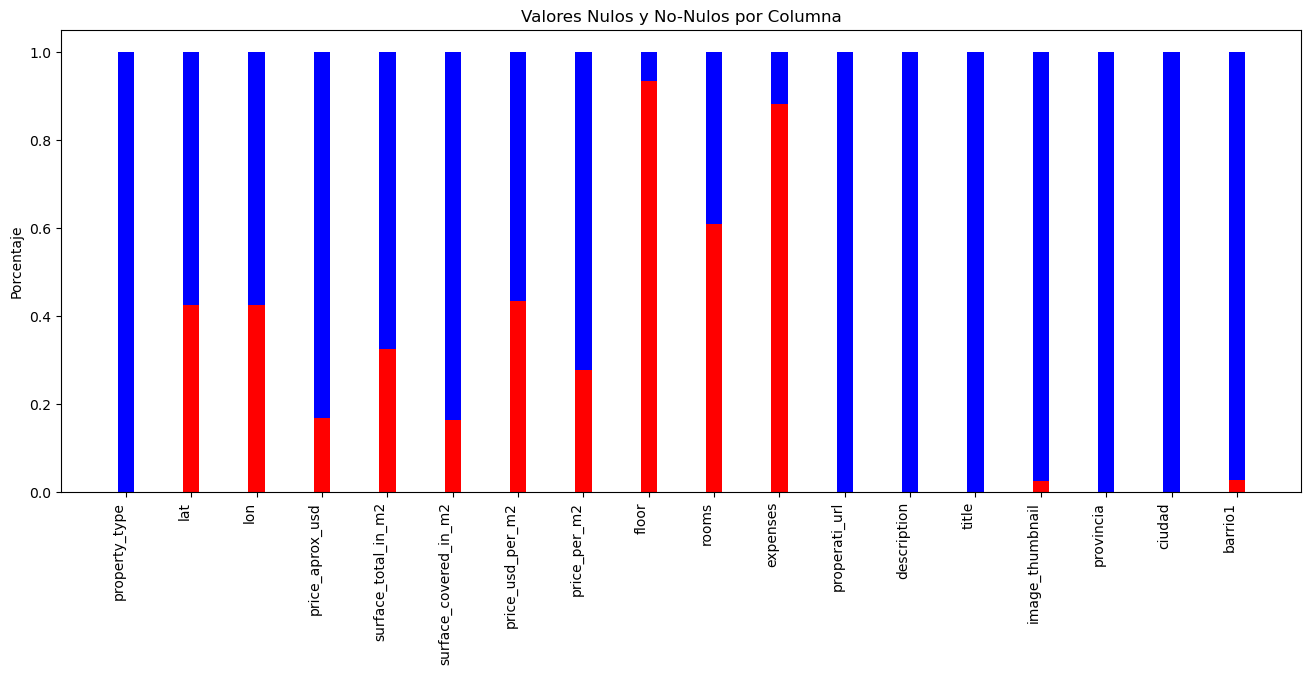

In [46]:
ind=datos.columns
ind_label=np.arange(0,datos.shape[1]-1)

valores_nulos=datos.isnull().sum()/datos.shape[0]

valores_no_nulos=datos.notnull().sum()/datos.shape[0]

width = 0.25

fig = plt.figure(figsize=(16,6)); ax = plt.axes()
#fig2= plt.figure(figsize=(16,6)); ax2 = plt.axes()

ax.bar(ind, valores_nulos, width, color='r') # barra roja. 
ax.bar(ind, valores_no_nulos, width, color='b',bottom=valores_nulos)
#ax2.bar(ind, valores_no_nulos, width, color='b')#, bottom=valores_no_nulos) # barra azul 

ax.set_ylabel('Porcentaje'); ax.set_title('Valores Nulos y No-Nulos por Columna')
#ax.set_xticks(ind); 
ax.set_xticklabels(ind)
ax.tick_params(axis='both', which='minor', labelsize='small')

ax.set_xticklabels(ind, rotation = 90, ha="right")
#ax2.set_xticklabels(ind,labelsize=8)
#ax.legend(labels=['Men', 'Women'])

#plt.gca().invert_xaxis()
plt.show()

# Roberto: empezamos con el procesamiento de la columna descripción para encontrar data relevante:

In [47]:
# recorre el campo description y llama la funcion CuentaPalabras en cada registro y va sumando palabra y cantidad de cada registro
# Genera un DataFrame CantPalabras con las dos listas
listPalabras = []
listCantidad = []



### ANALIZAR SI CONVIENE REDEFINIR LA FUNCIÓN CUENTAPALABRAS:

AHORA MISMO MODIFICA LAS LISTAS DEFINIDAS POR FUERA DE LA FUNCIÓN, SERÍA MEJOR
UTILIZAR UN RETURN

In [48]:
SerieAmbiente = datos['description']
patron_amb = '\d\s+[Aa]mbiente'
patron_regex_amb = re.compile(patron_amb)
Ambiente = SerieAmbiente.apply(lambda x: np.NaN if len(patron_regex_amb.findall(str(x)))==0
                               else (patron_regex_amb.findall(str(x))[0])[0])
datos['ambientes'] = Ambiente

In [49]:
datos['ambientes'].isnull().sum()

98892

In [50]:
mask_amb=datos['ambientes'].notnull() & datos['rooms'].isnull() 

In [51]:
#se pueden imputar 11 mil datos de la columna ambietnes a rooms
mask_amb.sum()


11559

In [52]:
datos['rooms'].isnull().sum()

73830

Analisis de Cochera 

In [53]:
SerieCoch = datos['description']
patron_coch = '([Cc]ochera|[Gg]arage)'
patron_regex_coch = re.compile(patron_coch)
Cochera = SerieCoch.apply(lambda x: False if len(patron_regex_coch.findall(str(x)))==0 else True)
datos['cochera'] = Cochera

Añado Parrilla

In [54]:
SerieParrilla = datos['description']
patron_parrilla = '[Pp]arrilla'
patron_regex_parrilla = re.compile(patron_parrilla)
Parrilla = SerieParrilla.apply(lambda x: False if len(patron_regex_parrilla.findall(str(x)))==0 else True)
datos['parrilla'] = Parrilla

In [55]:
SeriePatio = datos['description']
patron_patio = '[Pp]atio'
patron_regex_patio = re.compile(patron_patio)
Patio = SeriePatio.apply(lambda x: False if len(patron_regex_patio.findall(str(x)))==0 else True)
datos['patio'] = Patio

In [56]:
SeriePileta = datos['description']
patron_pileta = '([Pp]ileta|[Pp]iscina)'
patron_regex_pileta = re.compile(patron_pileta)
Pileta = SeriePileta.apply(lambda x: False if len(patron_regex_pileta.findall(str(x)))==0 else True)
datos['pileta'] = Pileta

In [57]:
SerieVista = datos['description']
patron_vista = '([Aa]l\s[Ff]rente|[\s.,!/][Vv]istas*[\s.,!/)])'
patron_regex_vista = re.compile(patron_vista)
Vista = SerieVista.apply(lambda x: False if len(patron_regex_vista.findall(str(x)))==0 else True)
datos['vista'] = Vista

In [58]:
# cuando price_usd_m2 es nulo, o bien price_aprox_usd es nulo o surface_total_in_m2 es nulo
# por lo tanto no podemos conformarlo a partir de esos dos valores
datos_usdm2_null = datos[datos['price_usd_per_m2'].isnull()]

In [59]:
# Cuando price_usd_per_m2 es nulo hay muchos registros completos en price_per_m2
# Tomamos sólo los que se encuentran entre 1000 y 6000 que hacen pensar que se cargaron en el campo equivocado
# Son 17.817 valores que llevarían los 52.603 nulos de price_usd_per_m2 a 34.786

mask1 = datos_usdm2_null['price_per_m2'] < 6000
mask2 = datos_usdm2_null['price_per_m2'] > 500
Serie_price_per_m2 = datos_usdm2_null[mask1 & mask2]['price_per_m2']
datos['usd_per_m2_2'] = Serie_price_per_m2

### Desde acá analizamos el nuevo campo usd_per_m2_2 que complementa a price_usd_per_m2

In [60]:
mask20 = datos['price_usd_per_m2'].isnull() & datos['usd_per_m2_2'].notnull()

print(f'el campo price_usd_per_m2 cuenta con {datos.price_usd_per_m2.count()} datos no nulos')
print(f'el campo usd_per_m2_2  aporta {datos[mask20].usd_per_m2_2.count()} valores no nulos al campo price_usd_per_m2')


el campo price_usd_per_m2 cuenta con 68617 datos no nulos
el campo usd_per_m2_2  aporta 19966 valores no nulos al campo price_usd_per_m2


In [61]:
#Comparamos promedio y desvío estándard de las combinaciones provincia/ciudad/property_type que más valores tenemos en el campo nuevo de precio
#Al campo original (price_usd_per_m2) lo limitamos entre 500 y 6000 ya que el campo nuevo sólo lo agregamos en ese rango


maskm2 = (datos['price_usd_per_m2'] > 500) & (datos['price_usd_per_m2'] < 6000) | (datos['usd_per_m2_2'].notnull())
masknoCap = datos['provincia'] != 'Capital Federal'
datos_agrup =datos[maskm2 & masknoCap].groupby(['provincia', 'ciudad', 'property_type']).agg({'price_usd_per_m2': ['mean', 'std', 'count'], 
                                                             'usd_per_m2_2': ['mean', 'std', 'count']})
datos_agrup.sort_values(('usd_per_m2_2', 'count'), ascending=False).head(15)


price_usd_per_m2  \
                                                                       mean   
provincia                    ciudad          property_type                    
Buenos Aires Costa Atlántica Mar del Plata   apartment          1986.896177   
Bs.As. G.B.A. Zona Norte     Tigre           house              1639.454885   
Bs.As. G.B.A. Zona Sur       Lomas de Zamora house              1353.224498   
Bs.As. G.B.A. Zona Norte     Tigre           apartment          2376.631307   
Córdoba                      Córdoba         house               889.641567   
Bs.As. G.B.A. Zona Norte     Vicente López   apartment          3063.957543   
Bs.As. G.B.A. Zona Sur       La Plata        house              1339.969649   
Bs.As. G.B.A. Zona Oeste     La Matanza      apartment          1751.969835   
Bs.As. G.B.A. Zona Norte     San Isidro      house              1443.511966   
                             Escobar         house              1272.935898   
Bs.As. G.B.A. Zona Sur       Lomas de Zamora apartment          2007.972072   
                             La Plata        apartment          1754.927357   
Bs.As. G.B.A. Zona Norte     Pilar           house              1417.256507   
Bs.As. G.B.A. Zona Oeste     Morón           apartment          1762.455910   
Bs.As. G.B.A. Zona Norte     Vicente López   house              1576.729160   

                                                                              \
                                                                   std count   
provincia                    ciudad          property_type                     
Buenos Aires Costa Atlántica Mar del Plata   apartment      539.483595  3466   
Bs.As. G.B.A. Zona Norte     Tigre           house          694.365804  2936   
Bs.As. G.B.A. Zona Sur       Lomas de Zamora house          474.131192   433   
Bs.As. G.B.A. Zona Norte     Tigre           apartment      643.255606  2914   
Córdoba                      Córdoba         house          339.074551   210   
Bs.As. G.B.A. Zona Norte     Vicente López   apartment      849.464267  1363   
Bs.As. G.B.A. Zona Sur       La Plata        house          580.974937   265   
Bs.As. G.B.A. Zona Oeste     La Matanza      apartment      506.831824   389   
Bs.As. G.B.A. Zona Norte     San Isidro      house          608.869569   950   
                             Escobar         house          433.624570   793   
Bs.As. G.B.A. Zona Sur       Lomas de Zamora apartment      506.828392   815   
                             La Plata        apartment      496.831600   598   
Bs.As. G.B.A. Zona Norte     Pilar           house          505.266135  1202   
Bs.As. G.B.A. Zona Oeste     Morón           apartment      442.554520   667   
Bs.As. G.B.A. Zona Norte     Vicente López   house          588.072260   726   

                                                           usd_per_m2_2  \
                                                                   mean   
provincia                    ciudad          property_type                
Buenos Aires Costa Atlántica Mar del Plata   apartment      1939.210364   
Bs.As. G.B.A. Zona Norte     Tigre           house          1951.398657   
Bs.As. G.B.A. Zona Sur       Lomas de Zamora house          1384.156061   
Bs.As. G.B.A. Zona Norte     Tigre           apartment      2499.103360   
Córdoba                      Córdoba         house          1255.528798   
Bs.As. G.B.A. Zona Norte     Vicente López   apartment      3070.254809   
Bs.As. G.B.A. Zona Sur       La Plata        house          1492.484930   
Bs.As. G.B.A. Zona Oeste     La Matanza      apartment      1971.952269   
Bs.As. G.B.A. Zona Norte     San Isidro      house          1874.288131   
                             Escobar         house          1425.429927   
Bs.As. G.B.A. Zona Sur       Lomas de Zamora apartment      2150.514590   
                             La Plata        apartment      1698.321391   
Bs.As. G.B.A. Zona Norte     Pilar           house          1462.80447

In [62]:
maskm2 = (datos['price_usd_per_m2'] > 500) & (datos['price_usd_per_m2'] < 6000) | (datos['usd_per_m2_2'].notnull())
masknoCap = datos['provincia'] == 'Capital Federal'
datos_agrup =datos[maskm2 & masknoCap].groupby(['ciudad', 'barrio1', 'property_type']).agg({'price_usd_per_m2': ['mean', 'std', 'count'], 
                                                             'usd_per_m2_2': ['mean', 'std', 'count']})
datos_agrup.sort_values(('usd_per_m2_2', 'count'), ascending=False).head(15)

price_usd_per_m2               \
                                                        mean          std   
ciudad          barrio1       property_type                                 
Capital Federal Palermo       apartment          3267.368270   885.445453   
                Belgrano      apartment          3103.608970   755.599333   
                Caballito     apartment          2473.293396   479.477095   
                Recoleta      apartment          3253.156680   844.546704   
                Villa Urquiza apartment          2540.308867   422.938569   
                Flores        apartment          2083.413897   388.891222   
                Monserrat     apartment          2134.715442   562.656036   
                Balvanera     apartment          1954.858611   480.799102   
                San Telmo     apartment          2375.152130   567.877259   
                Nuñez         apartment          3060.117617   859.737583   
                Almagro       apartment          2248.286685   502.465890   
                Villa Crespo  apartment          2548.230588   503.147813   
                Barrio Norte  apartment          3000.903922   856.912873   
                San Cristobal apartment          2240.282509  1108.599814   
                Floresta      apartment          1913.494005   347.763150   

                                                  usd_per_m2_2              \
                                            count         mean         std   
ciudad          barrio1       property_type                                  
Capital Federal Palermo       apartment      2573  3163.330657  887.100077   
                Belgrano      apartment      1932  3062.154112  758.910102   
                Caballito     apartment      1550  2430.778342  570.699880   
                Recoleta      apartment      1090  3072.140606  786.529508   
                Villa Urquiza apartment       970  2520.946062  548.497952   
                Flores        apartment       839  2021.531467  359.774317   
                Monserrat     apartment       274  2243.269970  422.047788   
                Balvanera     apartment       415  1906.616812  400.384843   
                San Telmo     apartment       918  2320.995845  466.261080   
                Nuñez         apartment       458  3053.258287  693.584771   
                Almagro       apartment       706  2222.833961  378.694497   
                Villa Crespo  apartment       873  2467.204556  558.492324   
                Barrio Norte  apartment       818  2675.966357  545.611518   
                San Cristobal apartment       211  2078.085641  387.333403   
                Floresta      apartment       191  1966.045062  443.407371   

                                                   
                                            count  
ciudad          barrio1       property_type        
Capital Federal Palermo       apartment       453  
                Belgrano      apartment       324  
                Caballito     apartment       297  
                Recoleta      apartment       199  
                Villa Urquiza apartment       183  
                Flores        apartment       173  
                Monserrat     apartment       158  
                Balvanera     apartment       131  
                San Telmo     apartment       126  
                Nuñez         apartment       122  
                Almagro       apartment       117  
                Villa Crespo  apartment       106  
                Barrio Norte  apartment        99  
                San Cristobal apartment        82  
                Floresta      apartment        80

In [63]:
datos['price_usd_per_m2'] = datos.apply(lambda x: x['price_usd_per_m2'] if x['price_usd_per_m2'] > 1 else x['usd_per_m2_2'], axis=1)

In [64]:
datos.price_usd_per_m2.notnull().sum()

88581

### Verificamos outliers en el campo price_usd_per_m2

<AxesSubplot:xlabel='price_usd_per_m2', ylabel='Count'>

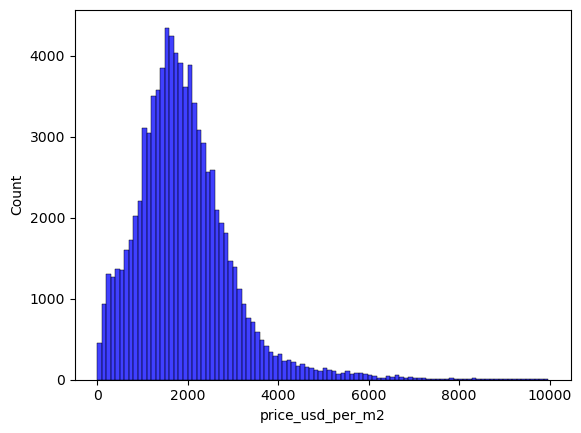

In [65]:
mask = datos.price_usd_per_m2 < 10000
sns.histplot(datos[mask].price_usd_per_m2, color='blue', bins=100)

In [66]:
mask = datos.price_usd_per_m2 < 500
print(f'en todo el país hay {datos[mask].price_usd_per_m2.count()} de menos de 500 usd x m2')

mask1 = datos.price_usd_per_m2 > 6000
print(f'en todo el país hay {datos[mask1].price_usd_per_m2.count()} de más de 6000 usd x m2')


en todo el país hay 5333 de menos de 500 usd x m2
en todo el país hay 1489 de más de 6000 usd x m2


In [67]:
mask2 = (datos.price_usd_per_m2 < 500) | (datos.price_usd_per_m2 > 6000)
datos_outliers_usd = datos[mask2].groupby(['provincia', 'ciudad', 'barrio1', 'property_type']).agg({'price_usd_per_m2': 'count'})
datos_outliers_usd.sort_values('price_usd_per_m2', ascending=False).head(7)

price_usd_per_m2
provincia                    ciudad           barrio1       property_type                  
Capital Federal              Capital Federal  Boedo         apartment                   403
Buenos Aires Costa Atlántica Mar del Plata                  house                       368
Bs.As. G.B.A. Zona Norte     Tigre            Benavidez     house                       264
Capital Federal              Capital Federal  Puerto Madero apartment                   218
                                              San Cristobal apartment                   193
Bs.As. G.B.A. Zona Norte     Pilar                          house                       177
Córdoba                      Villa Carlos Paz               house                       151

In [68]:
# Capital Federal | Capital Federal | Boedo | apartment con price_usd_per_m2 < 500 y mayor a 6000
# en el 100% de los cosas corresponden a proyectos desde el pozo 
# en casi todos los casos price_usd_per_m2 = price_per_m2 pero no guardan relación ni en $ ni en usd con 'description'
# vemos cuantos quedan entre 500 y 6000 usd en la misma zona paraa el mismo property_type
maskboedo = (datos.price_usd_per_m2 > 500) & (datos.price_usd_per_m2 < 6000) &\
             (datos.provincia == 'Capital Federal') & (datos.ciudad == 'Capital Federal') &\
             (datos.barrio1 == 'Boedo') & (datos.property_type == 'apartment')
datos[maskboedo].price_usd_per_m2.count() # quedan 357 en el dataset con las mismas características

357

In [69]:
# eliminamos entonces los 403 que no son consistentes
maskboedodrop = ((datos.price_usd_per_m2 < 500) | (datos.price_usd_per_m2 > 6000)) &\
             (datos.provincia == 'Capital Federal') & (datos.ciudad == 'Capital Federal') &\
             (datos.barrio1 == 'Boedo') & (datos.property_type == 'apartment')
listboedodrop = datos[maskboedodrop].index
datos = datos.drop(listboedodrop, axis=0)

In [70]:
# Buenos Aires Costa Atlántica | Mar del Plata |  | house con price_usd_per_m2 < 500 y mayor a 6000
# todos con precios en usd x m2 debajo de 500 - pudimos chequear con el campo description valores correctos de 309, 450 y 442
# maskMardel = (datos.index==9529)
# datos[maskMardel][['price_usd_per_m2', 'surface_total_in_m2']]
# eliminamos sólo los que tienen price_usd_per_m2 < 300 - 186 registros
maskMardel = (datos.price_usd_per_m2 < 300) &\
             (datos.provincia == 'Buenos Aires Costa Atlántica') & (datos.ciudad == 'Mar del Plata') &\
             (datos.property_type == 'house')
listMardeldrop = datos[maskMardel].index
datos = datos.drop(listMardeldrop, axis=0)

In [71]:
# Bs.As. G.B.A. Zona Norte | Tigre | Benavidez | house con price_usd_per_m2 < 500 y mayor a 6000
# todos con precios x m2 debajo de 500 - pudimos chequear con el campo description valores correctos 120, 187, 246 y 300
# el mínimo valor es 110 por lo cual no eliminamos ninguno
# maskTigre = (datos.index==110636)
# datos[maskTigre][['price_usd_per_m2', 'surface_total_in_m2']]

In [72]:
# Capital Federal | Capital Federal | Puerto Madero | apartment con price_usd_per_m2 < 500 y mayor a 6000
# son todos apartments con precios x m2 entre 6000 y 10000
# dejamos todos

In [73]:
# Capital Federal | Capital Federal | San Cristobal | apartment con price_usd_per_m2 < 500 y mayor a 6000
# en el 100% de los cosas corresponden a proyectos desde el pozo 
# en casi todos los casos price_usd_per_m2 = price_per_m2 pero no guardan relación ni en $ ni en usd con 'description'
# vemos cuantos quedan entre 500 y 6000 usd en la misma zona paraa el mismo property_type
maskSanCrist = (datos.price_usd_per_m2 > 500) & (datos.price_usd_per_m2 < 6000) &\
             (datos.provincia == 'Capital Federal') & (datos.ciudad == 'Capital Federal') &\
             (datos.barrio1 == 'San Cristobal') & (datos.property_type == 'apartment')
datos[maskSanCrist].price_usd_per_m2.count() # quedan 293 en el dataset con las mismas características

293

In [74]:
# eliminamos entonces los 193 que no son consistentes
maskSanCristdrop = ((datos.price_usd_per_m2 < 500) | (datos.price_usd_per_m2 > 6000)) &\
             (datos.provincia == 'Capital Federal') & (datos.ciudad == 'Capital Federal') &\
             (datos.barrio1 == 'San Cristobal') & (datos.property_type == 'apartment')
listSanCristdrop = datos[maskSanCristdrop].index
datos = datos.drop(listSanCristdrop, axis=0)

In [75]:
# BsAs. G.B.A. Zona Norte | Pilar | | house con price_usd_per_m2 < 500 y mayor a 6000
# las que están x debajo de 500 usd x m2 son todas reales muy afectadas por la superficie descubierta
# arriba de 6000 hay 3 que dropeamos
maskPilardrop = (datos.price_usd_per_m2 > 6000) &\
             (datos.provincia == 'Bs.As. G.B.A. Zona Norte') & (datos.ciudad == 'Pilar') &\
             (datos.property_type == 'house')
listPilardrop = datos[maskPilardrop].index
datos = datos.drop(listPilardrop, axis=0)
datos.shape

(120435, 25)

In [76]:
# Córdoba | Villa Carlos Paz | | house con price_usd_per_m2 < 500 y mayor a 6000
# todas debajo de 500 usd x m2 y verificado valores de 100 a 200
# dropeamos sólo debajo de 100 usd x m2 porque parecen casas muy destruídas
maskCarlosdrop = (datos.price_usd_per_m2 < 100) &\
                 (datos.provincia == 'Córdoba') & (datos.ciudad == 'Villa Carlos Paz') &\
                 (datos.property_type == 'house')
listCarlosDrop = datos[maskCarlosdrop].index
datos = datos.drop(listCarlosDrop, axis=0)
datos.shape

(120426, 25)

In [77]:
# Buenos Aires Costa Atlántica | Pinamar | | house con price_usd_per_m2 < 500 y mayor a 6000
# Son todas debajo de 500 usd y pudimos verificar rangos de 200 a 500
# dropeamos debajo de 200
maskPinadrop = (datos.price_usd_per_m2 < 200) &\
                 (datos.provincia == 'Buenos Aires Costa Atlántica') & (datos.ciudad == 'Pinamar') &\
                 (datos.property_type == 'house')
listPinaDrop = datos[maskPinadrop].index
datos = datos.drop(listPinaDrop, axis=0)
datos.shape

(120418, 25)

In [78]:
# Santa Fe | Rosario | | department con price_usd_per_m2 < 500 y mayor a 6000
# todos los vimos como errores < 500 no valida ninguno con 'description' > 6000 son emprendimientos desde el pozo y tampoco valida
maskRosario = (datos.price_usd_per_m2 > 500) & (datos.price_usd_per_m2 < 6000) &\
             (datos.provincia == 'Santa Fe') & (datos.ciudad == 'Rosario') &\
             (datos.property_type == 'apartment')
datos[maskRosario].price_usd_per_m2.count() # quedan 3300 en el dataset con las mismas características

3300

In [79]:
# eliminamos entonces los 119 que no son consistentes
maskRosariodrop = ((datos.price_usd_per_m2 < 500) | (datos.price_usd_per_m2 > 6000)) &\
             (datos.provincia == 'Santa Fe') & (datos.ciudad == 'Rosario') &\
             (datos.property_type == 'apartment')
listRosariodrop = datos[maskRosariodrop].index
datos = datos.drop(listRosariodrop, axis=0)

# Busqueda de outliers en variables de precio

<AxesSubplot:xlabel='price_usd_per_m2', ylabel='Count'>

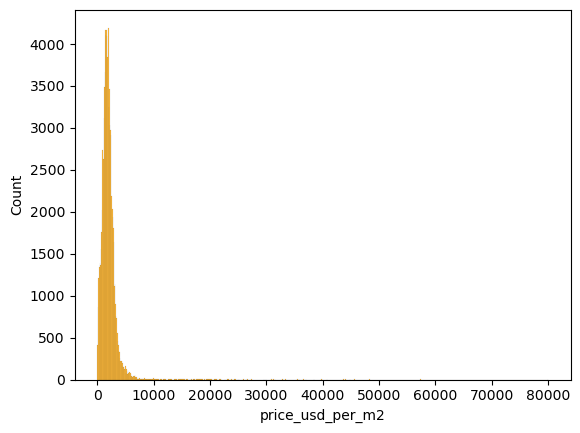

In [105]:
sns.histplot(datos['price_usd_per_m2'], color = "orange",binwidth=100)
#sns.histplot(data['y'], bins = 50);

creo que aca se ve tan feo el histograma porque hay outliers

In [106]:
precio_filtrado=datos['price_usd_per_m2']

In [109]:
precio_filtrado2=precio_filtrado.apply(lambda x: 0 if x>20000 else x)

<AxesSubplot:xlabel='price_usd_per_m2', ylabel='Count'>

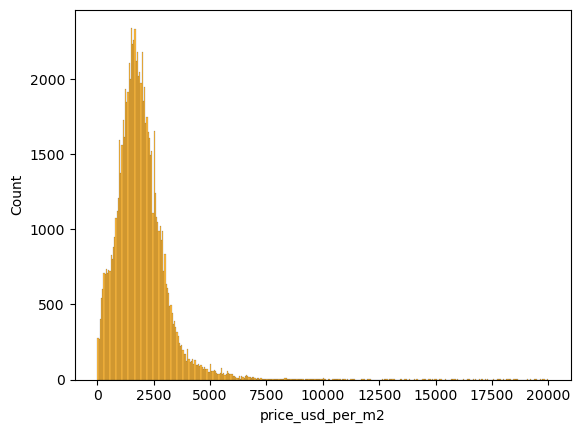

In [110]:
sns.histplot(precio_filtrado2, color = "orange")

<AxesSubplot:xlabel='price_aprox_usd', ylabel='Density'>

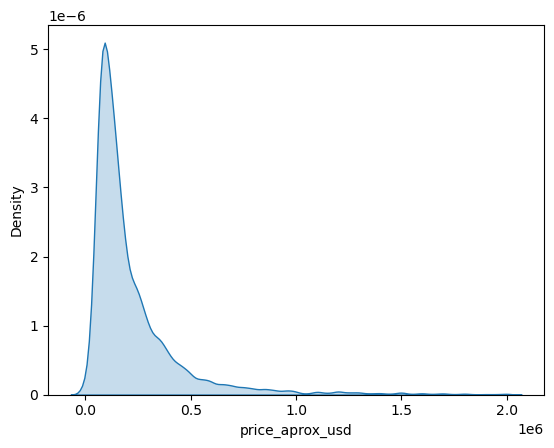

In [84]:
sns.kdeplot(precio_filtrado2, shade=True)

<AxesSubplot:xlabel='price_aprox_usd', ylabel='Density'>

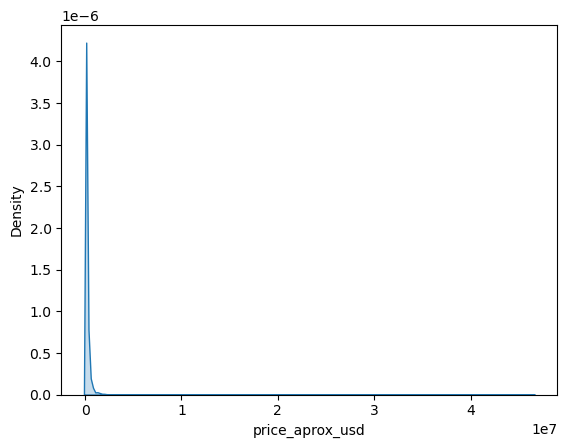

In [85]:
sns.kdeplot(precio_filtrado, shade=True)

c:\Users\fpeloso\Anaconda3\envs\dhdsblend2021\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price_aprox_usd'>

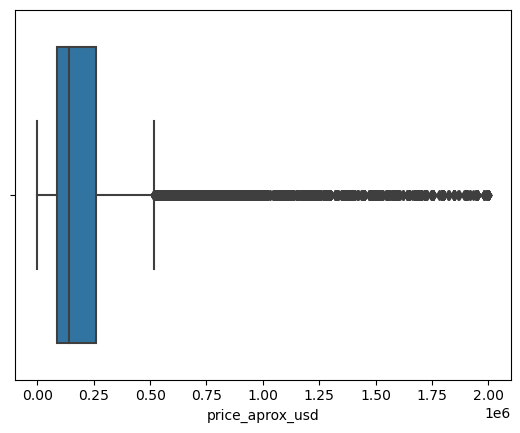

In [86]:
sns.boxplot(precio_filtrado2)

In [87]:

precio_por_provincia=datos[['price_aprox_usd','provincia']]

In [88]:
precio_medio_por_provincia=precio_por_provincia.groupby('provincia').mean()

In [89]:
precio_medio_por_provincia.head(10)
precio_medio_por_provincia

,price_aprox_usd
provincia,
Bs.As. G.B.A. Zona Norte,324142.230274
Bs.As. G.B.A. Zona Oeste,167545.648499
Bs.As. G.B.A. Zona Sur,198555.715572
Buenos Aires Costa Atlántica,143896.831339
Buenos Aires Interior,183249.996582
Capital Federal,261346.651424
Catamarca,725471.707308
Chaco,178583.551389
Chubut,342338.181524


In [90]:
#with sns.axes_style(style='ticks'):
 #   g= sns.scatterplot(x='provincia', y='price_aprox_usd',data=precio_medio_por_provincia)
  #  g.set_axis_labels("Provincia", "Precio Medio")
   # g.set_xticklabels(rotation=90) 

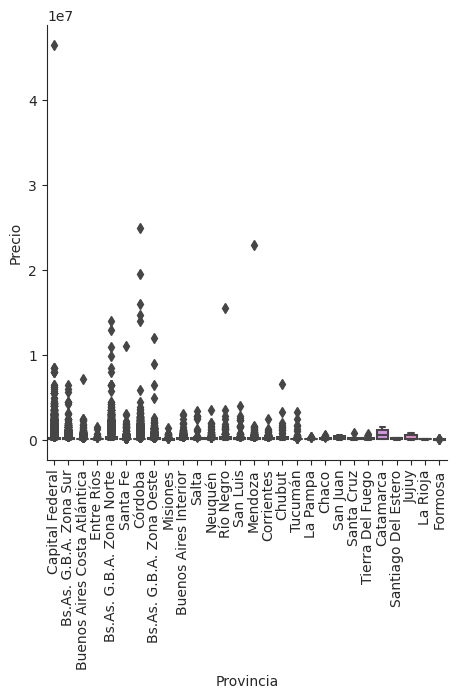

In [91]:
with sns.axes_style(style='ticks'):
    g = sns.catplot(x = "provincia", y = "price_aprox_usd", data=precio_por_provincia, kind="box")
    g.set_axis_labels("Provincia", "Precio")
    #ax.tick_params(axis='x', rotation=90)
    g.set_xticklabels(rotation=90) 

<AxesSubplot:xlabel='lon', ylabel='lat'>

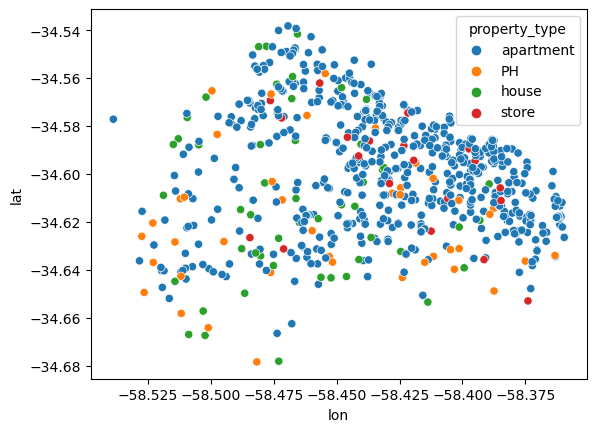

In [92]:
sns.scatterplot(data = datos[datos["ciudad"] == "Capital Federal"].sample(1000), x="lon", y="lat",hue='property_type')

In [93]:
comunas = pd.read_csv("https://cdn.buenosaires.gob.ar/datosabiertos/datasets/comunas/comunas.csv")

#display (comunas.head())
#Trasnformamos la columna WKT
comunas["WKT"] = comunas["WKT"].apply(shapely.wkt.loads) 

#display(comunas.head())

# Creamos el GeoComunas
geo_comunas = gpd.GeoDataFrame(comunas, geometry='WKT')
#display (geo_comunas.head())

In [94]:
geo_datos = gpd.GeoDataFrame(datos,geometry=gpd.points_from_xy(datos.lon, datos.lat))
geo_datos.head()

,property_type,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,...,ciudad,barrio1,ambientes,cochera,parrilla,patio,pileta,vista,usd_per_m2_2,geometry
0,PH,-34.661824,-58.508839,62000.0,55.0,40.0,1127.272727,1550.000000,NaN,NaN,...,Capital Federal,Mataderos,NaN,False,False,False,False,False,NaN,POINT (-58.50884 -34.66182)
1,apartment,-34.903883,-57.964330,150000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,La Plata,,NaN,True,False,False,False,True,NaN,POINT (-57.96433 -34.90388)
2,apartment,-34.652262,-58.522982,72000.0,55.0,55.0,1309.090909,1309.090909,NaN,NaN,...,Capital Federal,Mataderos,NaN,False,False,False,False,False,NaN,POINT (-58.52298 -34.65226)
3,PH,-34.647797,-58.516424,95000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,Capital Federal,Liniers,3,False,False,True,False,False,NaN,POINT (-58.51642 -34.64780)
4,apartment,-38.002626,-57.549447,64000.0,35.0,35.0,1828.571429,1828.571429,NaN,NaN,...,Mar del Plata,Centro,NaN,False,False,False,False,False,NaN,POINT (-57.54945 -38.00263)


<AxesSubplot:>

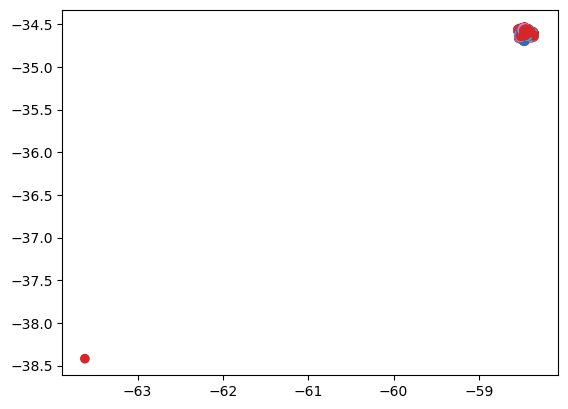

In [95]:
fig, ax = plt.subplots()

#geo_arboles.sample(1000).plot(ax=ax, column = "nombre_cientifico")
geo_comunas.plot(ax=ax, facecolor="none", edgecolor='black')
geo_datos.loc[geo_datos['ciudad']=='Capital Federal'].plot(ax=ax, column='property_type')


In [96]:
#Vemos que hay un valor erroneo, no esta en capital federal su ubicación de lat lon
propiedades_caba=geo_datos.loc[geo_datos['ciudad']=='Capital Federal']

In [97]:
lejanas=propiedades_caba.lat < -38

In [98]:
caba_cercanas=propiedades_caba.lat > -38

In [99]:
caba_grafico=propiedades_caba.loc[caba_cercanas]
caba_grafico.head()

,property_type,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,...,ciudad,barrio1,ambientes,cochera,parrilla,patio,pileta,vista,usd_per_m2_2,geometry
0,PH,-34.661824,-58.508839,62000.0,55.0,40.0,1127.272727,1550.000000,NaN,NaN,...,Capital Federal,Mataderos,NaN,False,False,False,False,False,NaN,POINT (-58.50884 -34.66182)
2,apartment,-34.652262,-58.522982,72000.0,55.0,55.0,1309.090909,1309.090909,NaN,NaN,...,Capital Federal,Mataderos,NaN,False,False,False,False,False,NaN,POINT (-58.52298 -34.65226)
3,PH,-34.647797,-58.516424,95000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,Capital Federal,Liniers,3,False,False,True,False,False,NaN,POINT (-58.51642 -34.64780)
7,apartment,-34.559873,-58.443362,138000.0,45.0,40.0,3066.666667,3450.000000,NaN,NaN,...,Capital Federal,Belgrano,NaN,False,False,False,False,False,NaN,POINT (-58.44336 -34.55987)
8,apartment,-34.559873,-58.443362,195000.0,65.0,60.0,3000.000000,3250.000000,NaN,NaN,...,Capital Federal,Belgrano,NaN,False,False,False,False,False,NaN,POINT (-58.44336 -34.55987)


<AxesSubplot:>

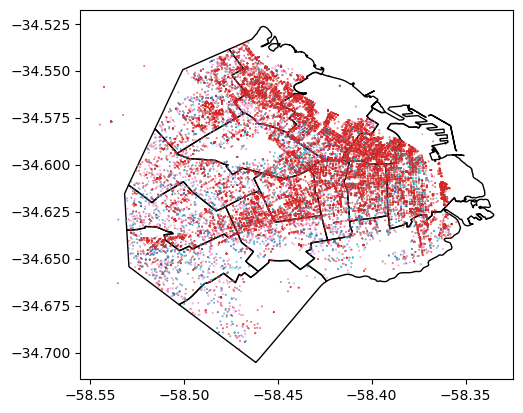

In [100]:
fig, ax = plt.subplots()

#geo_arboles.sample(1000).plot(ax=ax, column = "nombre_cientifico")
geo_comunas.plot(ax=ax, facecolor="none", edgecolor='black')
caba_grafico.loc[caba_grafico['ciudad']=='Capital Federal'].plot(ax=ax, column='property_type',markersize=0.1,marker='o')

In [101]:
display(propiedades_caba[lejanas])


,property_type,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,...,ciudad,barrio1,ambientes,cochera,parrilla,patio,pileta,vista,usd_per_m2_2,geometry
28512,apartment,-38.416097,-63.616672,45000.0,70.0,70.0,642.857143,642.857143,NaN,3.0,...,Capital Federal,Mataderos,NaN,False,False,False,False,False,NaN,POINT (-63.61667 -38.41610)


In [102]:
datos.loc[28512]

property_type                                                    apartment
lat                                                               -38.4161
lon                                                               -63.6167
price_aprox_usd                                                      45000
surface_total_in_m2                                                     70
surface_covered_in_m2                                                   70
price_usd_per_m2                                                   642.857
price_per_m2                                                       642.857
floor                                                                  NaN
rooms                                                                    3
expenses                                                               NaN
properati_url            http://www.properati.com.ar/17wcl_venta_depart...
description              Dueño directo vende departamento de 3 amb. amp...
title                    

## Lectura de columna comentarios para obtener datos y validar otros campos

## Categorizar los ambientes

## Análisis usando groupby (ciudades, barrios, provincias)

## Uso de tablas pivot para visualizar relaciones entre parámetros